### 0. Imports

In [ ]:
%load_ext autoreload
%autoreload 2

# Data transformation
# ------------------------------------------------------
import pandas as pd
import numpy as np
import math

# Visualizations
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

# Preprocessing 
# ------------------------------------------------------
from sklearn.preprocessing import RobustScaler



# Handle warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("once")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# modify system variables
# -----------------------------------------------------------------------
import sys
sys.path.append("..") # append parent folder to path

# modify operating system structures
# -----------------------------------------------------------------------
import os

# import support functions
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.soporte_clustering as sc
import src.data_visualization_support as dvs
import src.soporte_outliers as so

seed=42

# 1. Intro to clustering v2 notebook and data import

## 1.1 Introduction

The purporse of this clustering notebook is to re-evaluate features and preprocessing used for clustering.

## 1.2 Data import

In [3]:
global_superstore = pd.read_pickle("../data/cleaned/global_superstore.pkl")

# 2. Clustering - customers

## 2.1 Changes with respect to v1
- Repetition of both preprocessings but changing mean values for median values.

## 2.2 Aggregation

To cluster by customer, it is necessary for the data to have each row to represent each customer.

##### Calculate median orders month

In [4]:
global_superstore["year_month"] = global_superstore["order_date"].dt.to_period('M')
global_superstore["year_month"]

0        2012-07
1        2013-02
2        2013-10
3        2013-01
4        2013-11
          ...   
51285    2014-06
51286    2014-06
51287    2013-12
51288    2012-02
51289    2012-05
Name: year_month, Length: 51290, dtype: period[M]

In [5]:
median_purchase_freq = global_superstore.groupby(
    ["customer_id", "year_month"]
).agg(
    orders_month=("order_id", "nunique")
).groupby("customer_id").agg(median_orders_month=("orders_month","median"))

median_purchase_freq.head()

median_orders_month
customer_id                     
AA-10315                     1.0
AA-10375                     1.0
AA-10480                     1.0
AA-10645                     1.0
AB-10015                     1.0

##### median ticket per order

In [6]:
global_superstore.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'market', 'product_id',
       'category', 'sub-category', 'product_name', 'sales', 'quantity',
       'discount', 'profit', 'shipping_cost', 'order_priority', 'year_month'],
      dtype='object')

In [7]:
median_ticket_order = global_superstore.groupby(
    ["customer_id", "order_id"]
).agg(
    total_spending_order=("sales", "sum"),
    total_shipping_cost_order=("shipping_cost", "sum"),

).groupby("customer_id"
          ).agg(
              median_spending_order=("total_spending_order", "median"),
              median_shipping_cost=("total_shipping_cost_order","median"))

median_ticket_order.head()

median_spending_order  median_shipping_cost
customer_id                                             
AA-10315                   270.600                32.955
AA-10375                    90.480                12.820
AA-10480                   386.520                22.140
AA-10645                   209.760                19.550
AB-10015                   309.592                51.970

#### Amount spent with respect to discount

First calculate discounted price [should be done priorly already]

In [8]:
global_superstore["discounted_price"] = global_superstore["sales"]/(1-global_superstore["discount"]) - global_superstore["sales"]
global_superstore["original_price"] = global_superstore["sales"] + global_superstore["discounted_price"]

##### Option 1 - median discount

In [9]:
amount_spent_customer = global_superstore.groupby(["customer_id","order_id"]).agg(
                                            total_original_price=("original_price","sum"),
                                            total_spent=("sales","sum")
                                            )
amount_spent_customer["discount"] = (1- amount_spent_customer["total_spent"]/amount_spent_customer["total_original_price"])
amount_spent_customer.head()

total_original_price  total_spent  discount
customer_id order_id                                                   
AA-10315    BO-2014-9240                  756.60      756.600   0.00000
            CA-2011-128055                894.94      726.548   0.18816
            CA-2011-138100                 29.50       29.500   0.00000
            CA-2012-121391                 26.96       26.960   0.00000
            CA-2013-103982               5507.59     4406.072   0.20000

In [10]:
amount_spent_customer = amount_spent_customer.groupby("customer_id").agg(
                                            total_original_price=("total_original_price","sum"),
                                            total_spent=("total_spent","sum"),
                                            median_discount=("discount","median")
                                            )
amount_spent_customer["median_discount"].hist()

<Axes: >

##### Option 2 - Correlation of spending with discounts

discount_corr
customer_id               
AA-10315          0.045609
AA-10375         -0.072842
AA-10480          0.130095
AA-10645          0.100239
AB-10015          0.244514

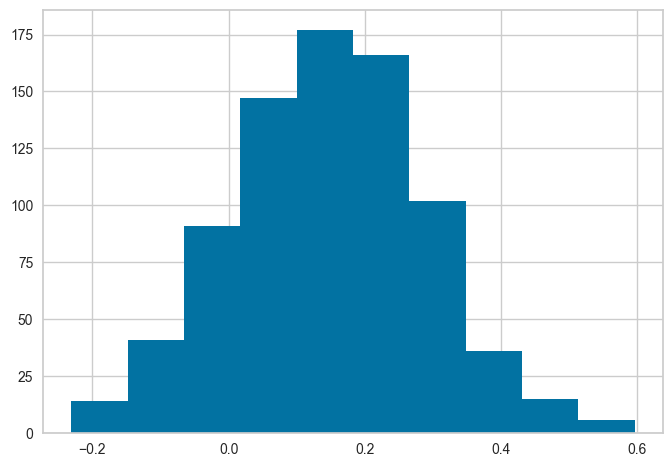

In [ ]:
# groupby client and calculate
corr_client = global_superstore.groupby('customer_id').apply(sc.calculate_discount_expense_correlation).reset_index()
corr_client.columns = ['customer_id', 'discount_corr']
corr_client.set_index("customer_id",inplace=True)
corr_client['discount_corr'].hist()
corr_client.head()

<Axes: xlabel='discounted_price', ylabel='sales'>

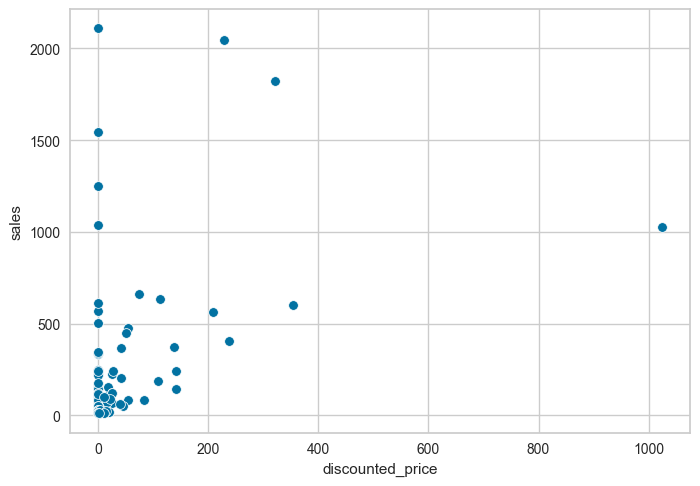

In [12]:
sns.scatterplot(data=global_superstore[global_superstore["customer_id"]=="AB-10015"],
                x="discounted_price",
                y="sales")

#### median quantity per order, median ppu per order

In [13]:
median_q_ppu_discount_order = (global_superstore.groupby(["customer_id", "order_id"]
                    ).agg(
                        total_spending_order=("sales", "sum"),
                        total_quantity=("quantity", "sum"),
                        total_discounted_price=("discounted_price","sum"))
                    .assign(unit_price_order=lambda df: df["total_spending_order"]/df["total_quantity"])
                    .groupby("customer_id")
                    .agg(
                        median_unit_price=("unit_price_order", "median"),
                        median_spending_order=("total_spending_order", "median"),
                        median_quantity_order=("total_quantity","median")))

median_q_ppu_discount_order.head()

median_unit_price  median_spending_order median_quantity_order
customer_id                                                               
AA-10315               46.038                270.600                   4.5
AA-10375            19.373625                 90.480                   4.0
AA-10480                68.07                386.520                   5.0
AA-10645             38.88637                209.760                   6.0
AB-10015                58.32                309.592                   7.0

#### Joining metrics

Version with median spending per order.

In [14]:
customer_aggregated_v1 = pd.concat([median_purchase_freq,median_ticket_order["median_spending_order"],
                                 amount_spent_customer["median_discount"],
                                 corr_client],axis=1)
print(f"The aggregated customer v1 df has {customer_aggregated_v1.shape[0]} rows")
customer_aggregated_v1.head()

The aggregated customer v1 df has 795 rows


median_orders_month  median_spending_order  median_discount  \
customer_id                                                                
AA-10315                     1.0                270.600         0.000000   
AA-10375                     1.0                 90.480         0.024334   
AA-10480                     1.0                386.520         0.100000   
AA-10645                     1.0                209.760         0.000000   
AB-10015                     1.0                309.592         0.000000   

             discount_corr  
customer_id                 
AA-10315          0.045609  
AA-10375         -0.072842  
AA-10480          0.130095  
AA-10645          0.100239  
AB-10015          0.244514

Highly correlated features impair outlier detection and clustering, therefore let's inspect correlation:

<Axes: >

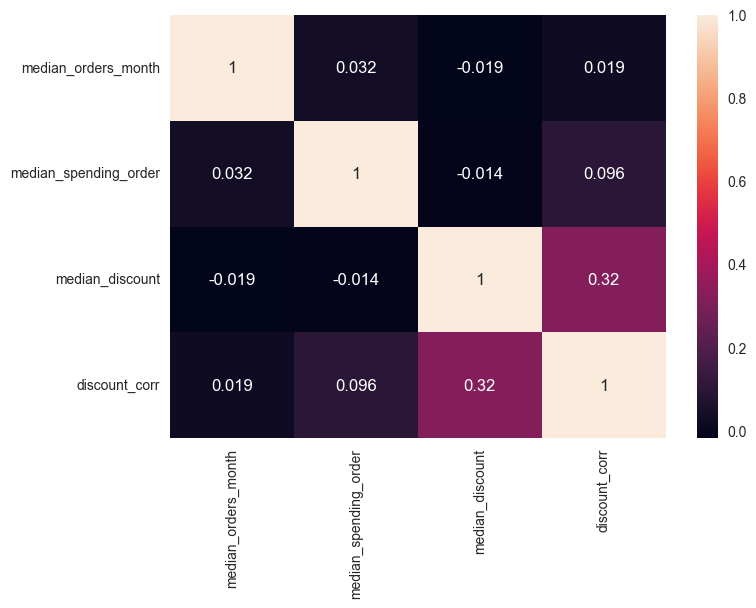

In [15]:
sns.heatmap(customer_aggregated_v1.corr(),annot=True)

Median_shipping_cost and median_spending_order are highly correlated. Hence, median_shipping_cost must be dropped:

In [16]:
customer_aggregated_v1.drop(columns="median_shipping_cost", inplace=True,errors="ignore")

Version with median ppu price and median quantity.

In [17]:
customer_aggregated_v2 = pd.concat([median_purchase_freq,
                                    median_q_ppu_discount_order[["median_unit_price","median_quantity_order"]],
                                 amount_spent_customer["median_discount"],
                                 corr_client],axis=1)
print(f"The aggregated customer v2 df has {customer_aggregated_v2.shape[0]} rows")
customer_aggregated_v2.head()

The aggregated customer v2 df has 795 rows


median_orders_month median_unit_price median_quantity_order  \
customer_id                                                                
AA-10315                     1.0            46.038                   4.5   
AA-10375                     1.0         19.373625                   4.0   
AA-10480                     1.0             68.07                   5.0   
AA-10645                     1.0          38.88637                   6.0   
AB-10015                     1.0             58.32                   7.0   

             median_discount  discount_corr  
customer_id                                  
AA-10315            0.000000       0.045609  
AA-10375            0.024334      -0.072842  
AA-10480            0.100000       0.130095  
AA-10645            0.000000       0.100239  
AB-10015            0.000000       0.244514

Highly correlated features impair outlier detection and clustering, therefore let's inspect correlation:

<Axes: >

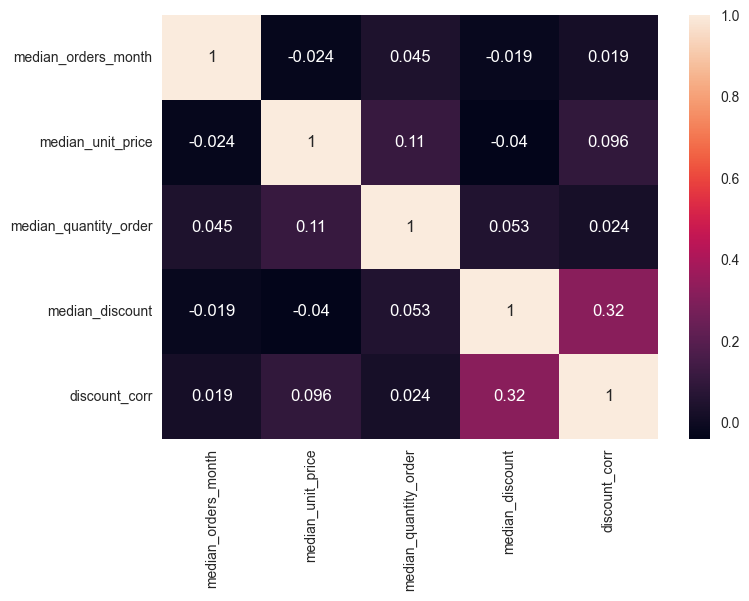

In [18]:
sns.heatmap(customer_aggregated_v2.corr(),annot=True)

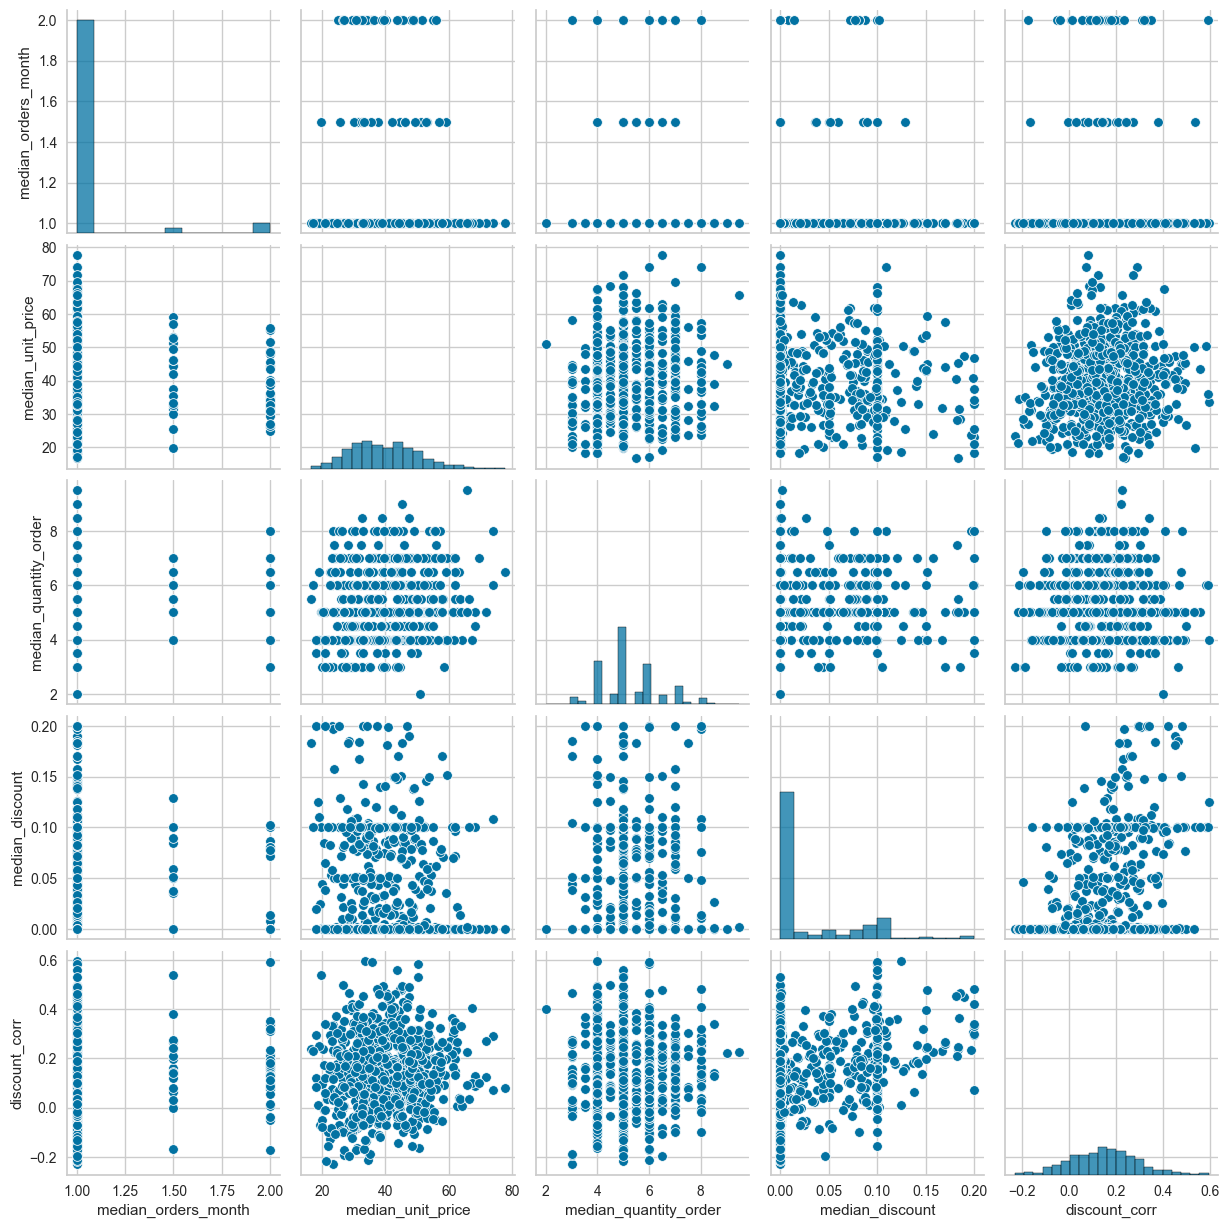

In [19]:
sns.pairplot(customer_aggregated_v2)

## 2.3 Preprocessing

Preprocessing should include categorical encoding, outlier handling and feature scaling. As for this iteration only numerical features are included, only feature scaling and outlier handling are needed.

#### Outlier handling

Contamination set to 2%.

Handle customer_aggregated_v1 first, then v2.

In [46]:
# detect v1
gestor_outliers = so.GestionOutliersMultivariados(customer_aggregated_v1)

customer_aggregated_v1_outliers = gestor_outliers.detectar_outliers_if(contaminacion=0.03, random_state=seed).replace({"outlier":{1:0,-1:1}})


# detect v2
gestor_outliers = so.GestionOutliersMultivariados(customer_aggregated_v2)

customer_aggregated_v2_outliers = gestor_outliers.detectar_outliers_if(contaminacion=0.03, random_state=seed).replace({"outlier":{1:0,-1:1}})

Inspecting the results via pairplots:

Pairplot of version 1


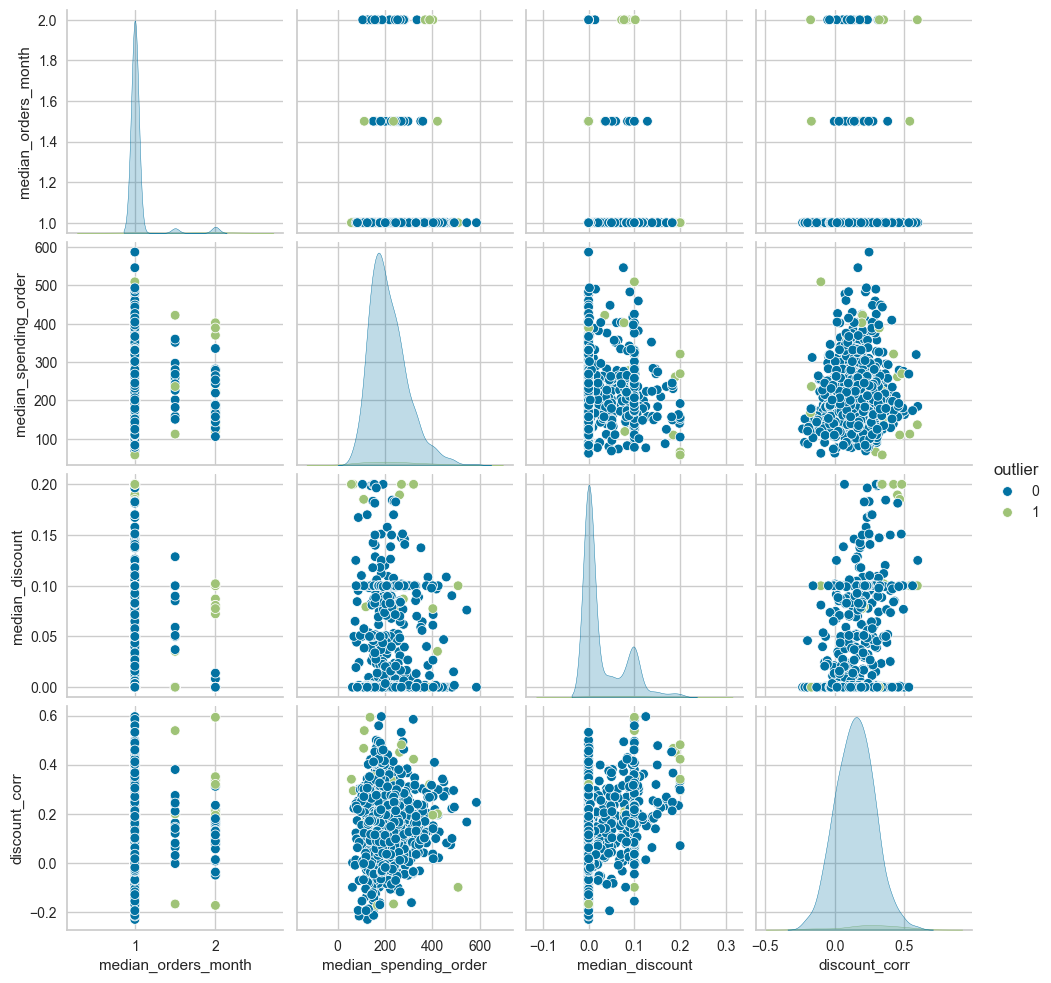



Pairplot of version 2


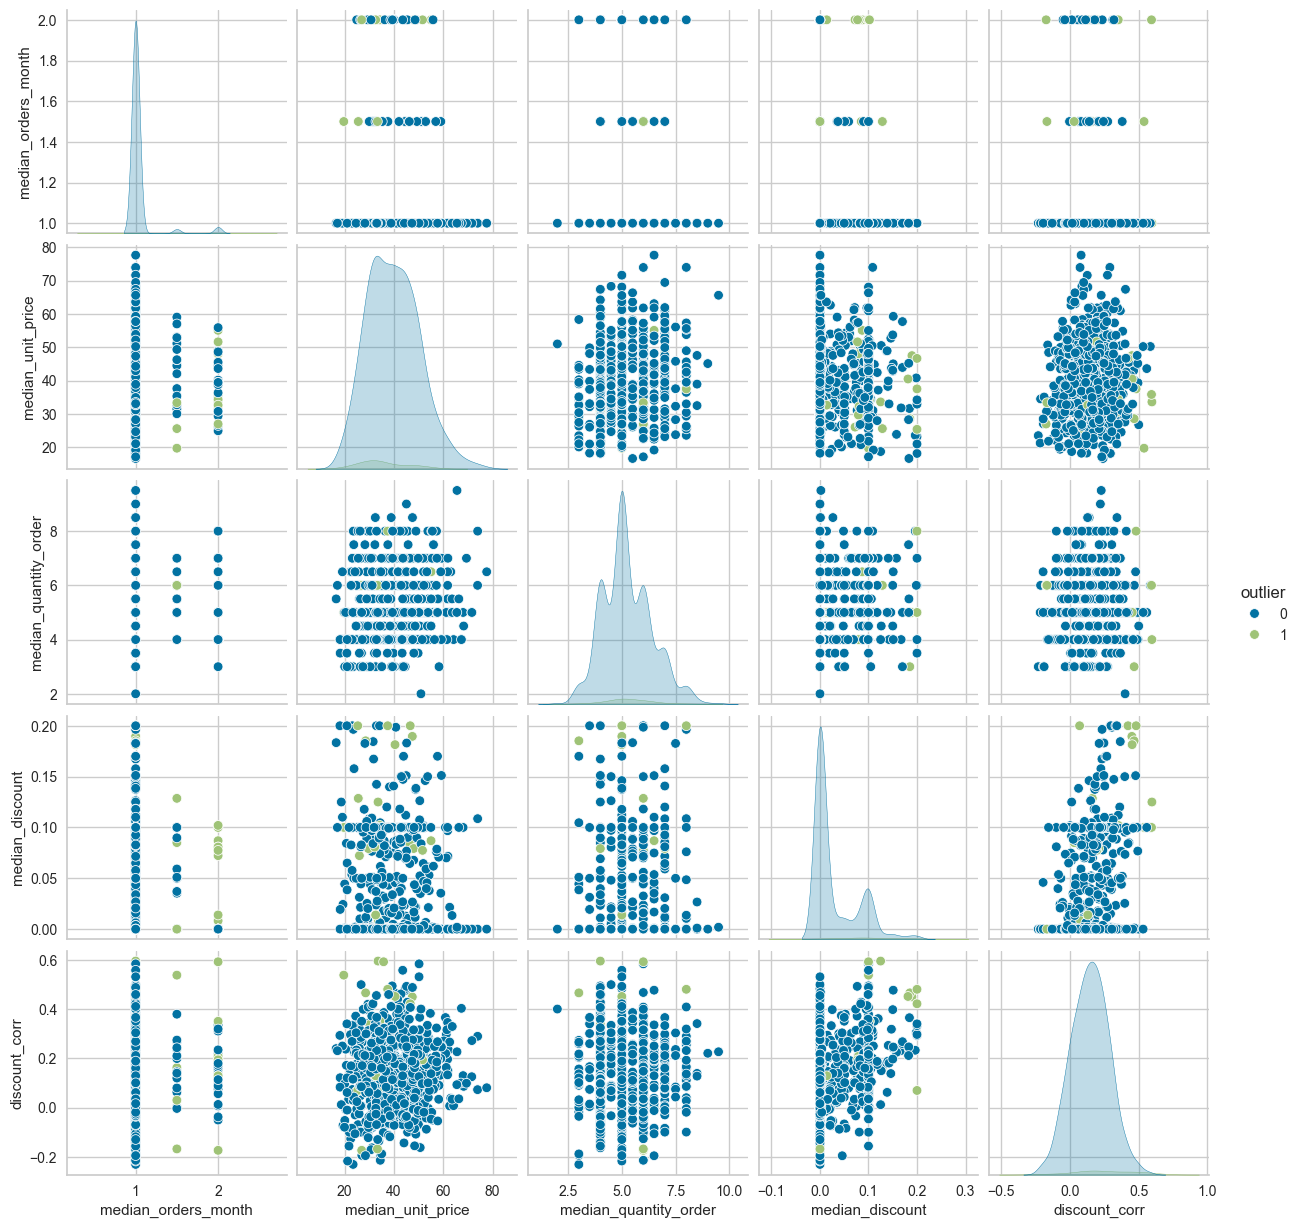

In [47]:
print("Pairplot of version 1") # cannot use titles apparently
sns.pairplot(customer_aggregated_v1_outliers, hue="outlier")
plt.show()

print("\n\nPairplot of version 2")
sns.pairplot(customer_aggregated_v2_outliers, hue="outlier")
plt.show()

Outliers detected visually look correct. To not introduce noise into the model, these records are better left out of the clustering process. Therefore:

In [48]:
customer_aggregated_v1_outliers = customer_aggregated_v1_outliers[customer_aggregated_v1_outliers["outlier"]==0].drop(columns="outlier")

customer_aggregated_v2_outliers = customer_aggregated_v2_outliers[customer_aggregated_v2_outliers["outlier"]==0].drop(columns="outlier")

##### Feature scaling

To retain the maximum information possible about distances, we use robust scaling.

In [49]:
scaler = RobustScaler()

customer_aggregated_v1_scaled = pd.DataFrame(scaler.fit_transform(customer_aggregated_v1_outliers),
                                             columns=customer_aggregated_v1_outliers.columns)
customer_aggregated_v1_scaled

customer_aggregated_v2_scaled = pd.DataFrame(scaler.fit_transform(customer_aggregated_v2_outliers),
                                             columns=customer_aggregated_v2_outliers.columns)
customer_aggregated_v2_scaled

median_orders_month  median_unit_price  median_quantity_order  \
0                    0.0           0.457753              -0.333333   
1                    0.0          -1.273300              -0.666667   
2                    0.0           1.888073               0.000000   
3                    0.0          -0.006531               0.666667   
4                    0.0           1.255102               1.333333   
..                   ...                ...                    ...   
766                  0.0          -0.929849              -0.333333   
767                  0.0           0.728276               0.000000   
768                  0.0           0.343622               0.000000   
769                  0.0          -0.696623               1.666667   
770                  0.0           0.540981               0.000000   

     median_discount  discount_corr  
0           0.000000      -0.520573  
1           0.461816      -1.135619  
2           1.897796      -0.081890  
3           0.000000      -0.236913  
4           0.000000       0.512221  
..               ...            ...  
766         0.000000       0.823558  
767         0.000000       2.005726  
768         0.000000      -0.672641  
769         3.465792       0.342368  
770         0.000000       0.224460  

[771 rows x 5 columns]

#### Visualize results

To get an intuition for the separability of the data, let's plot the pairplots for the scaled data.

Version 1 of customer aggregated data:

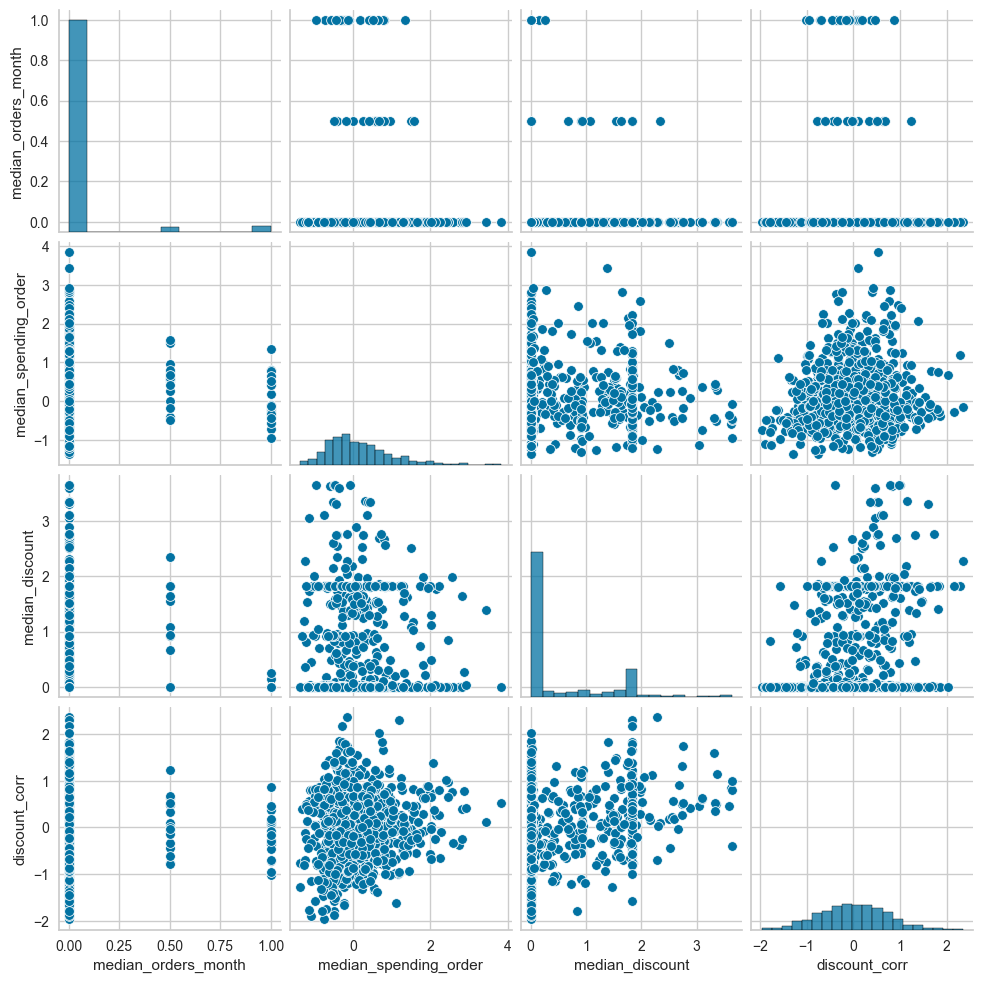

In [50]:
sns.pairplot(customer_aggregated_v1_scaled)

Version 2 of customer aggregated data:

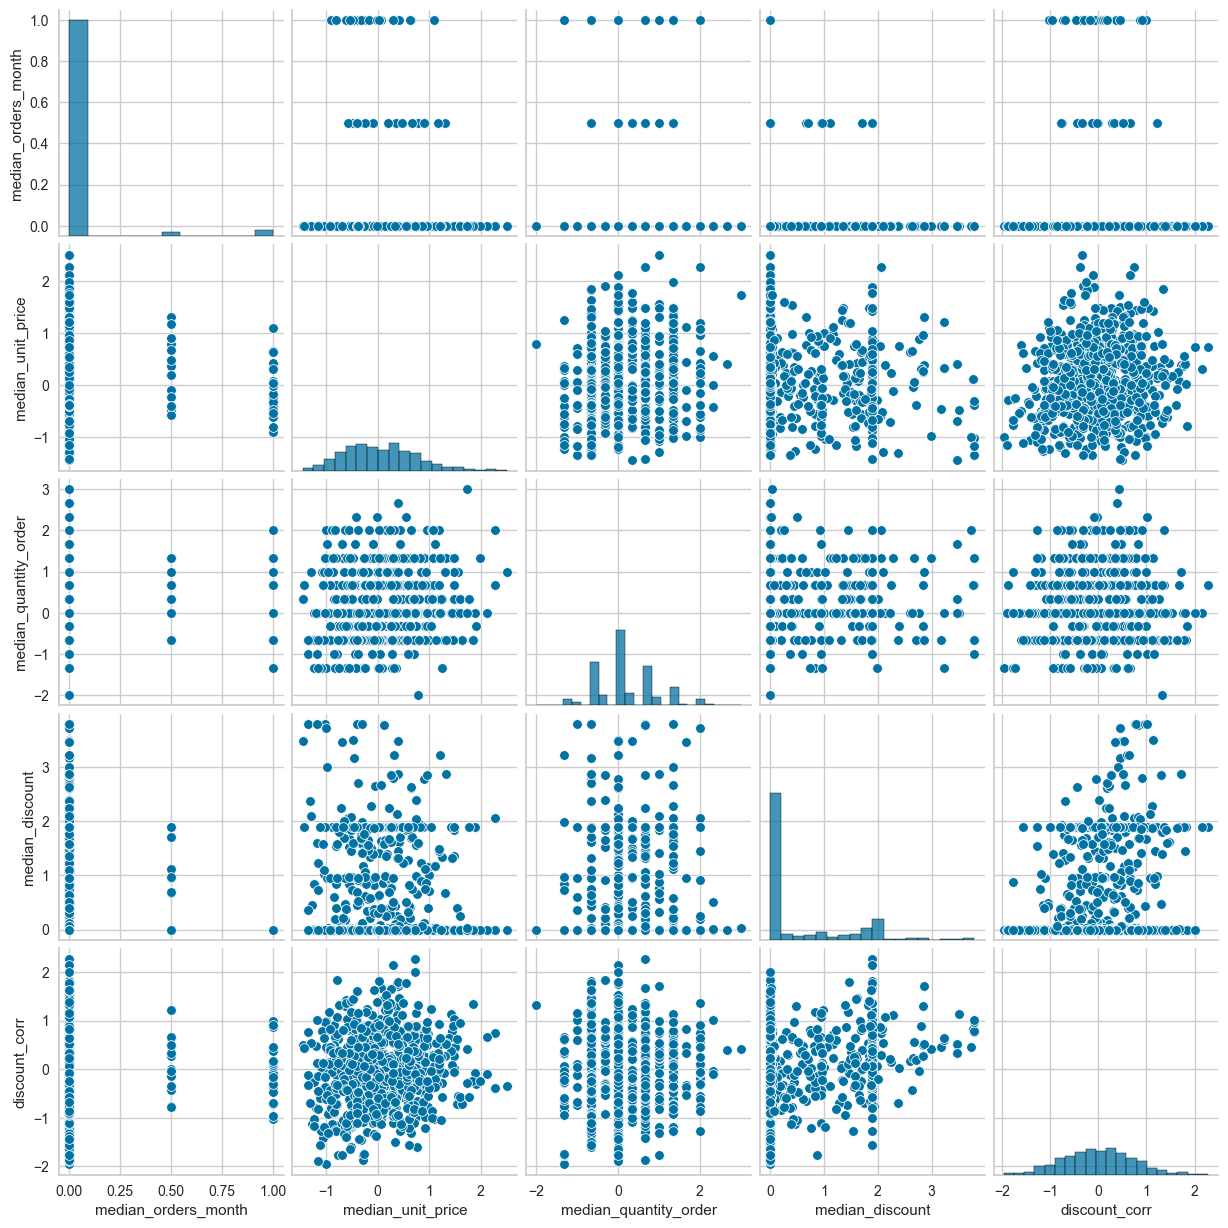

In [51]:
sns.pairplot(customer_aggregated_v2_scaled)

### Dimensionality reduction

The above pairplots do not show a single pairwise relationship that looks separable. There is a method for dimensionality reduction called t-SNE that helps visualize if data is separable even in a high dimensional space.

#### t-SNE

Applying t-SNE for version 1:

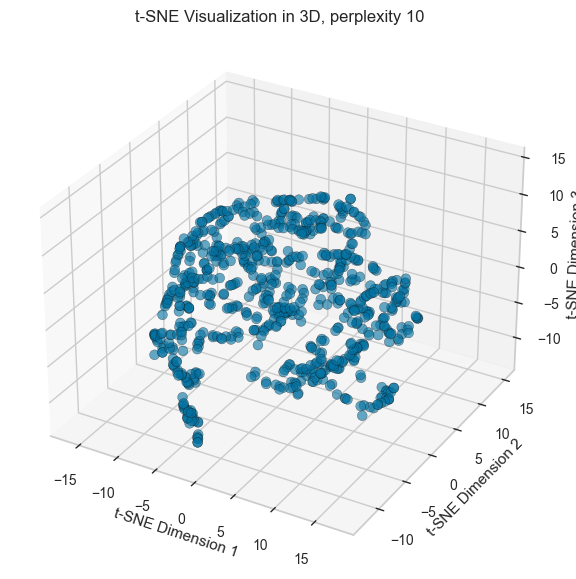

In [53]:
sc.t_sne(customer_aggregated_v1_scaled,dim=3,perplexity=10)

Applying t-SNE for version 2:

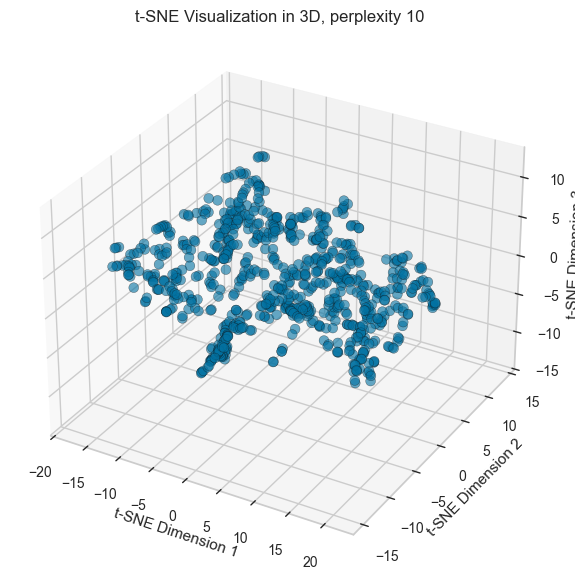

In [54]:
sc.t_sne(customer_aggregated_v2_scaled,dim=3,perplexity=10)

t-SNE does not show clearly separable clusters either, although the results depend highly on the perplexity parameter. 

There is another dimensionality reduction technique worth trying, PCA.

#### Principal Component Analysis (PCA)

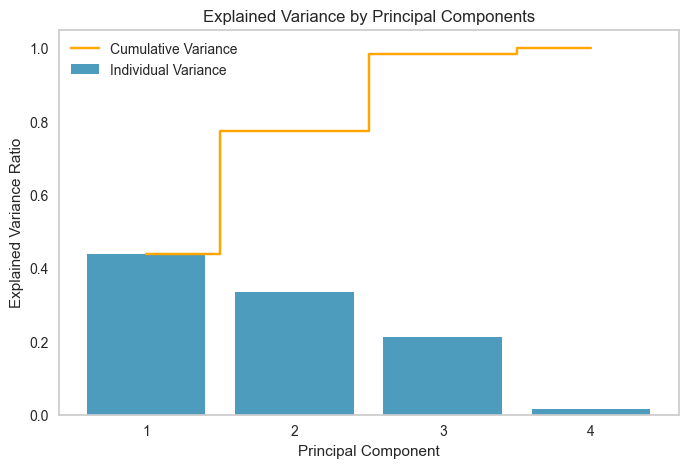

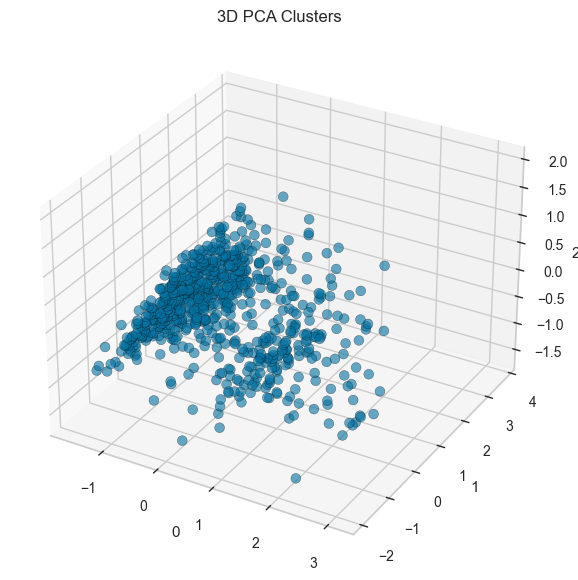

In [55]:
X_pca_v1 = sc.perform_PCA(customer_aggregated_v1_scaled)
sc.plot_3D_clusters(X_pca_v1)

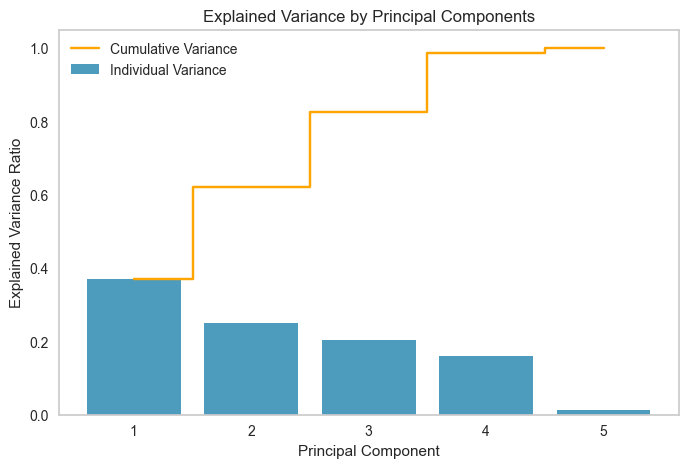

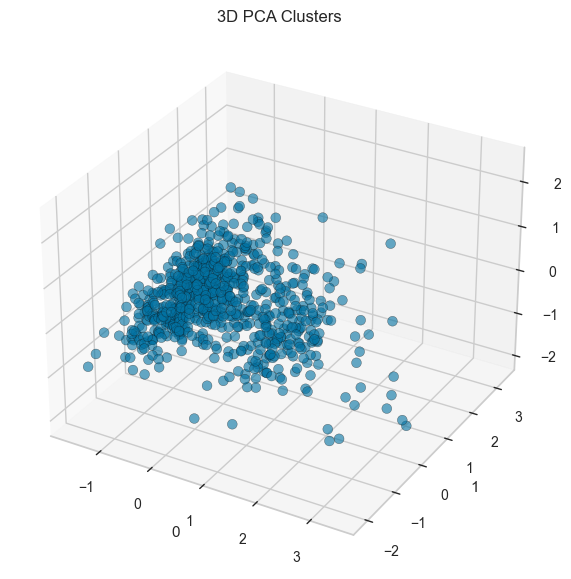

In [56]:
X_pca_v2 = sc.perform_PCA(customer_aggregated_v2_scaled)
sc.plot_3D_clusters(X_pca_v2)

PCA does not look like it does a great job separating features either. Besides, its best use is to reduce dimensions while retaining the most variance. In this case, the suggested subsets only have 5 and 6 features, and PCA does not achieve a good enough compression. Therefore, it will be left for later when encoded categorical features are introduced into the model.

# 2.4 Clustering

### 2.4.1 Kmeans

Searching for the most optimal number of clusters for kmeans, for the first combination of features:

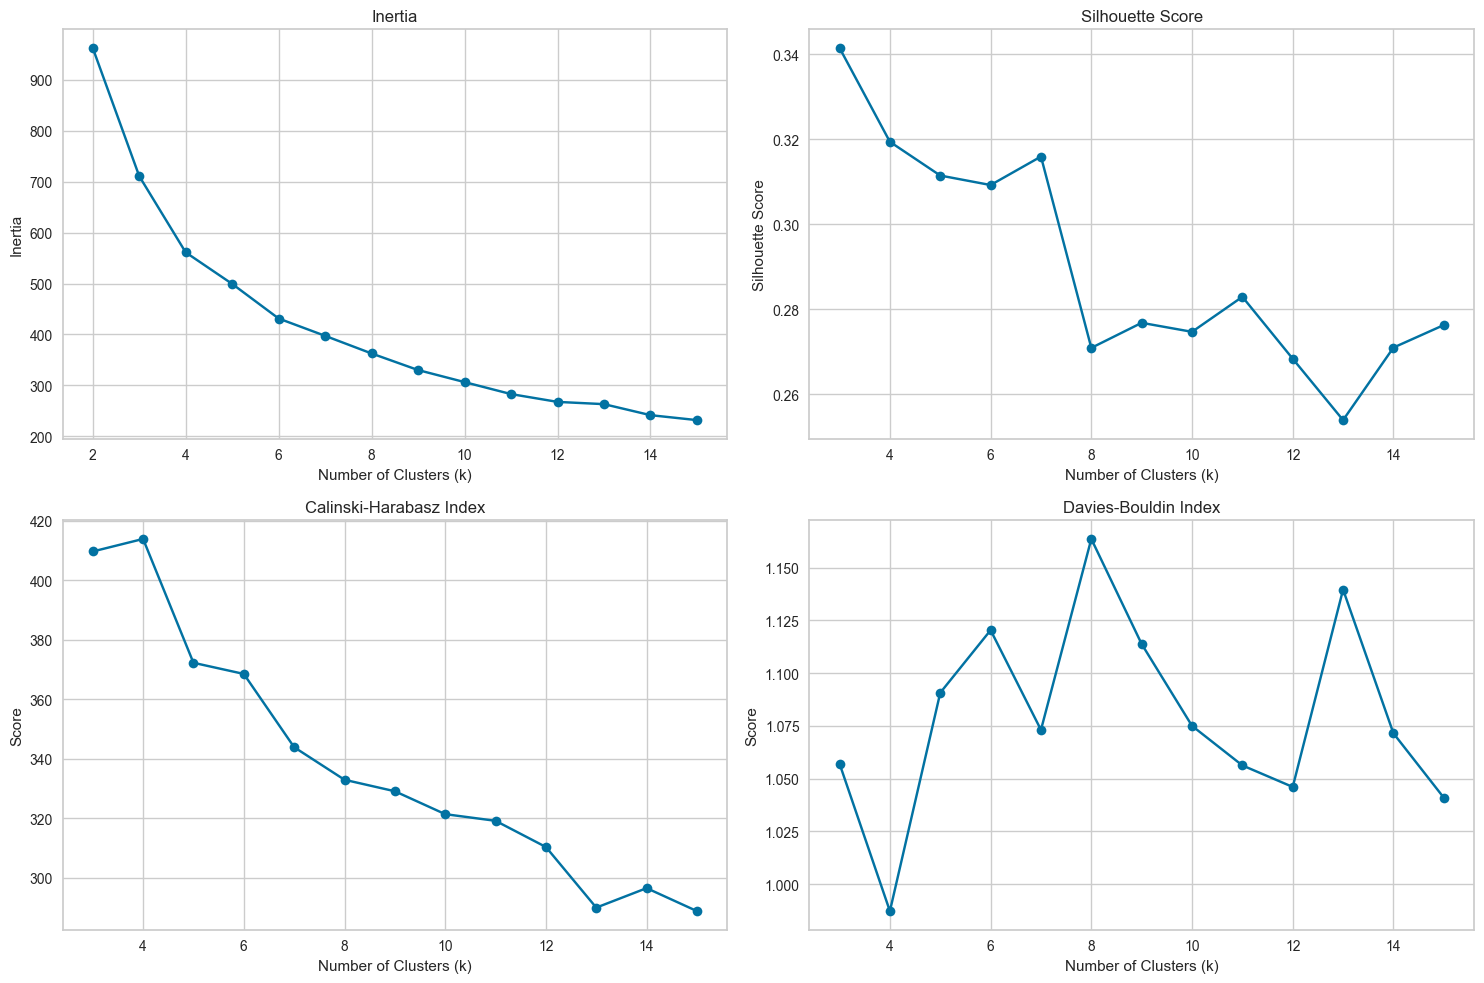

In [58]:
sc.choose_kmeans_k(customer_aggregated_v1_scaled, random_state=seed)

3 clusters looks like a good compromise of simplicity, high Silhouette score, high Calinski score and one of the lowest Davies-Bouldin.

4 clusters displays an even better compromise with lower inertia, lower Davies, higher Calinski and a bit lower silhouette. Besides, it can be a more specific set of clusters.

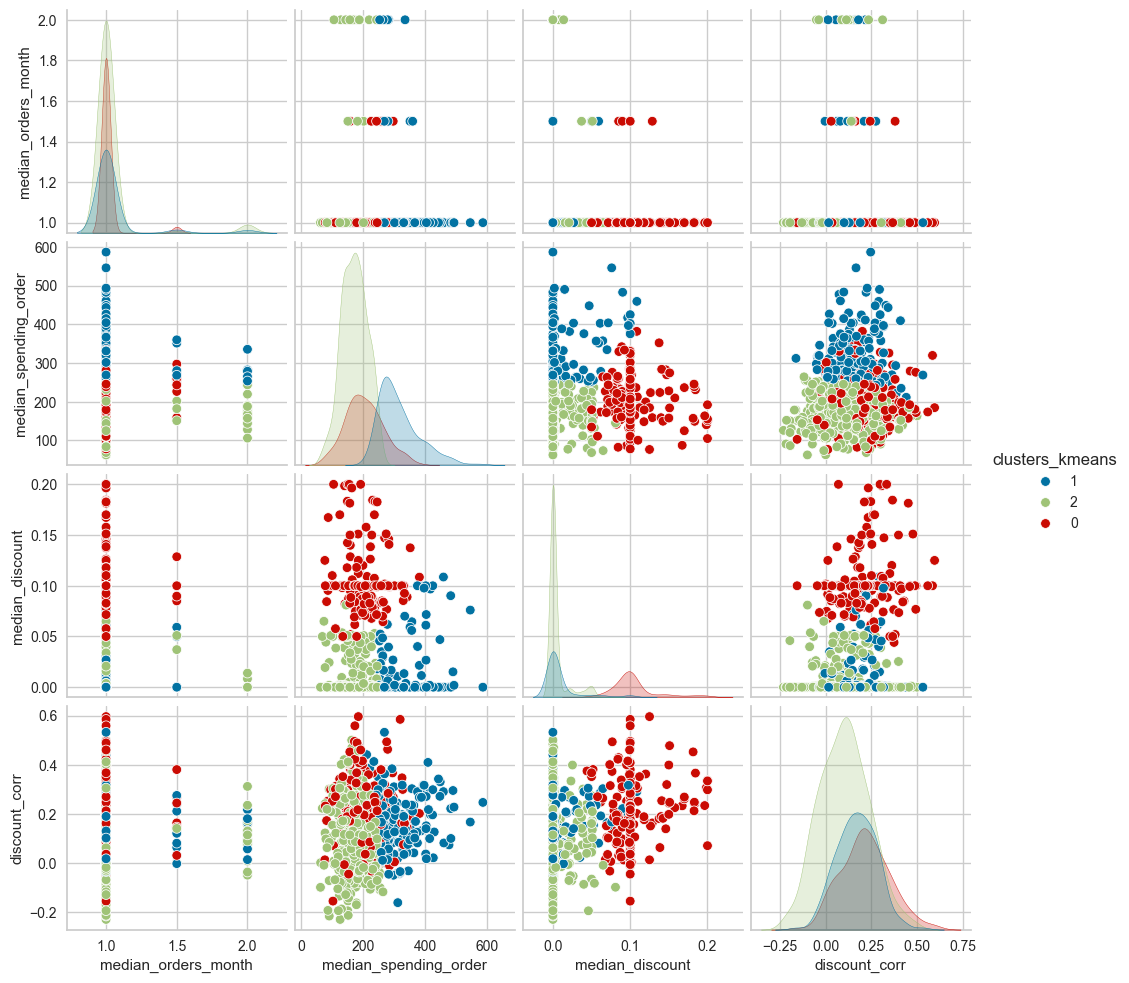

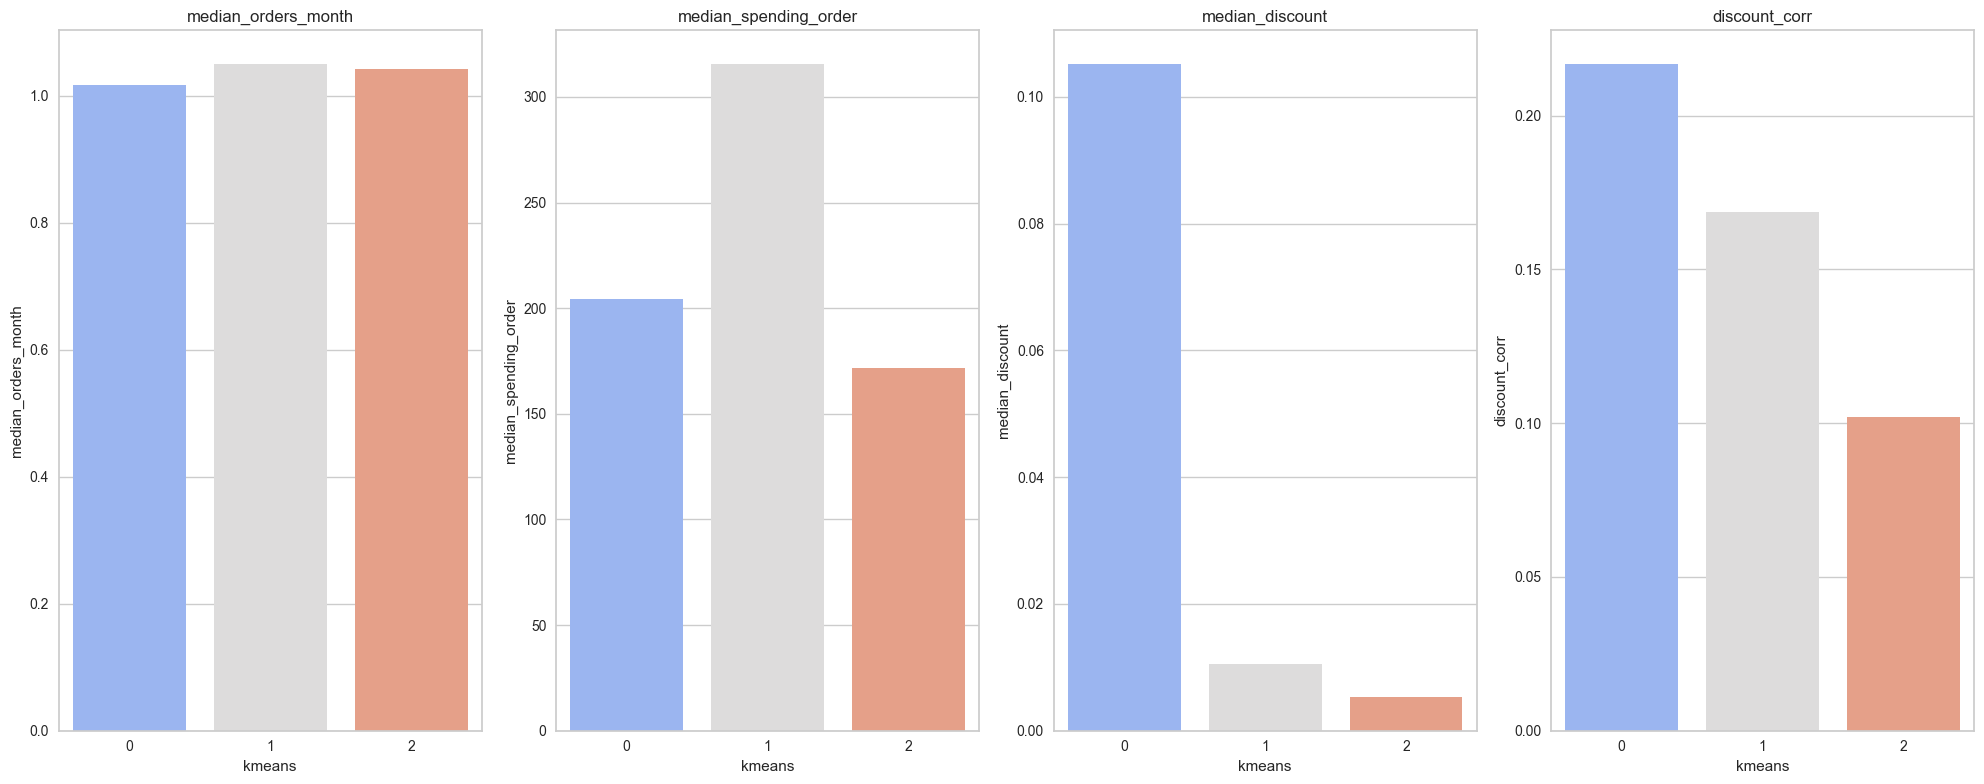

In [59]:
warnings.filterwarnings("ignore")
customer_aggregated_v1_outliers = customer_aggregated_v1_outliers.astype("float")
clusterizador_v1 = sc.Clustering(customer_aggregated_v1_outliers)

# 
clusterizador_v1.preparar_dataframe(scaler="robust")

customer_aggregated_v1_clustered = clusterizador_v1.modelo_kmeans(customer_aggregated_v1_outliers,3, random_state=seed)

sns.pairplot(customer_aggregated_v1_clustered, hue="clusters_kmeans")

clusterizador_v1.plot_clusters("kmeans")
warnings.filterwarnings("default")

In [60]:
clusterizador_v1.calcular_metricas("kmeans")

silhouette_score  davies_bouldin_index  cardinalidad
0          0.341524              1.057099           179

This set of 3 clusters divides very basically in:
- Cluster 0. Customers that do not tend to spend much (median_spending_order), react to discounts (spend more when there are, discount_corr) and have saved more on average (median_discount).
- Cluster 1. Customers that do not spend that much, but do not need discounts to spend and react the least to them.
- Cluster 2. Customers that react to discounts, but also tend to spend a lot.

All clusters share the same montly order frequency.

Below their cluster cardinality:

In [61]:
clusterizador_v1.calcular_metricas("kmeans")
print("Clustering cardinality:")
customer_aggregated_v1_clustered.groupby("clusters_kmeans").size()

Clustering cardinality:


clusters_kmeans
0    179
1    190
2    402
dtype: int64

Now let's inspect the same combination of features for 4 clusters:

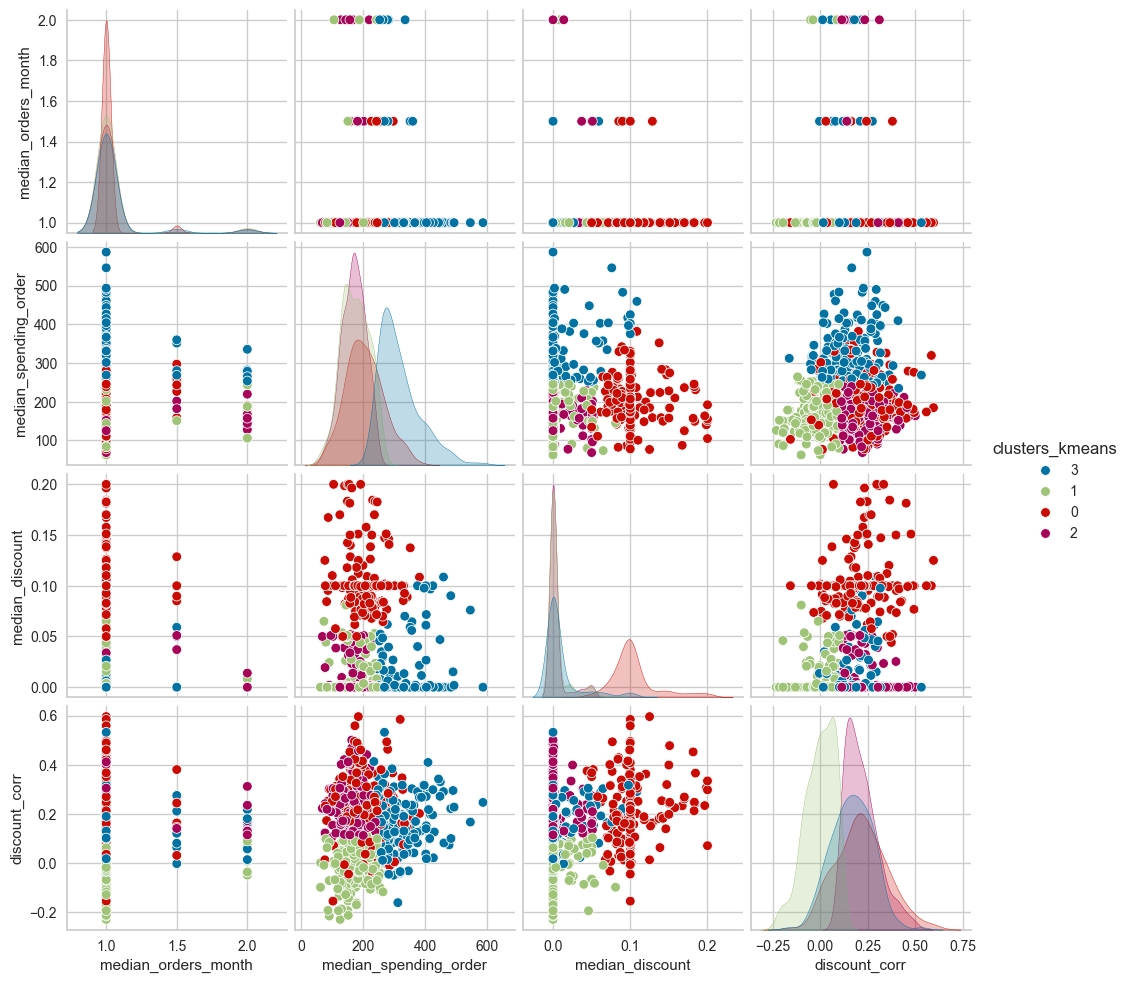

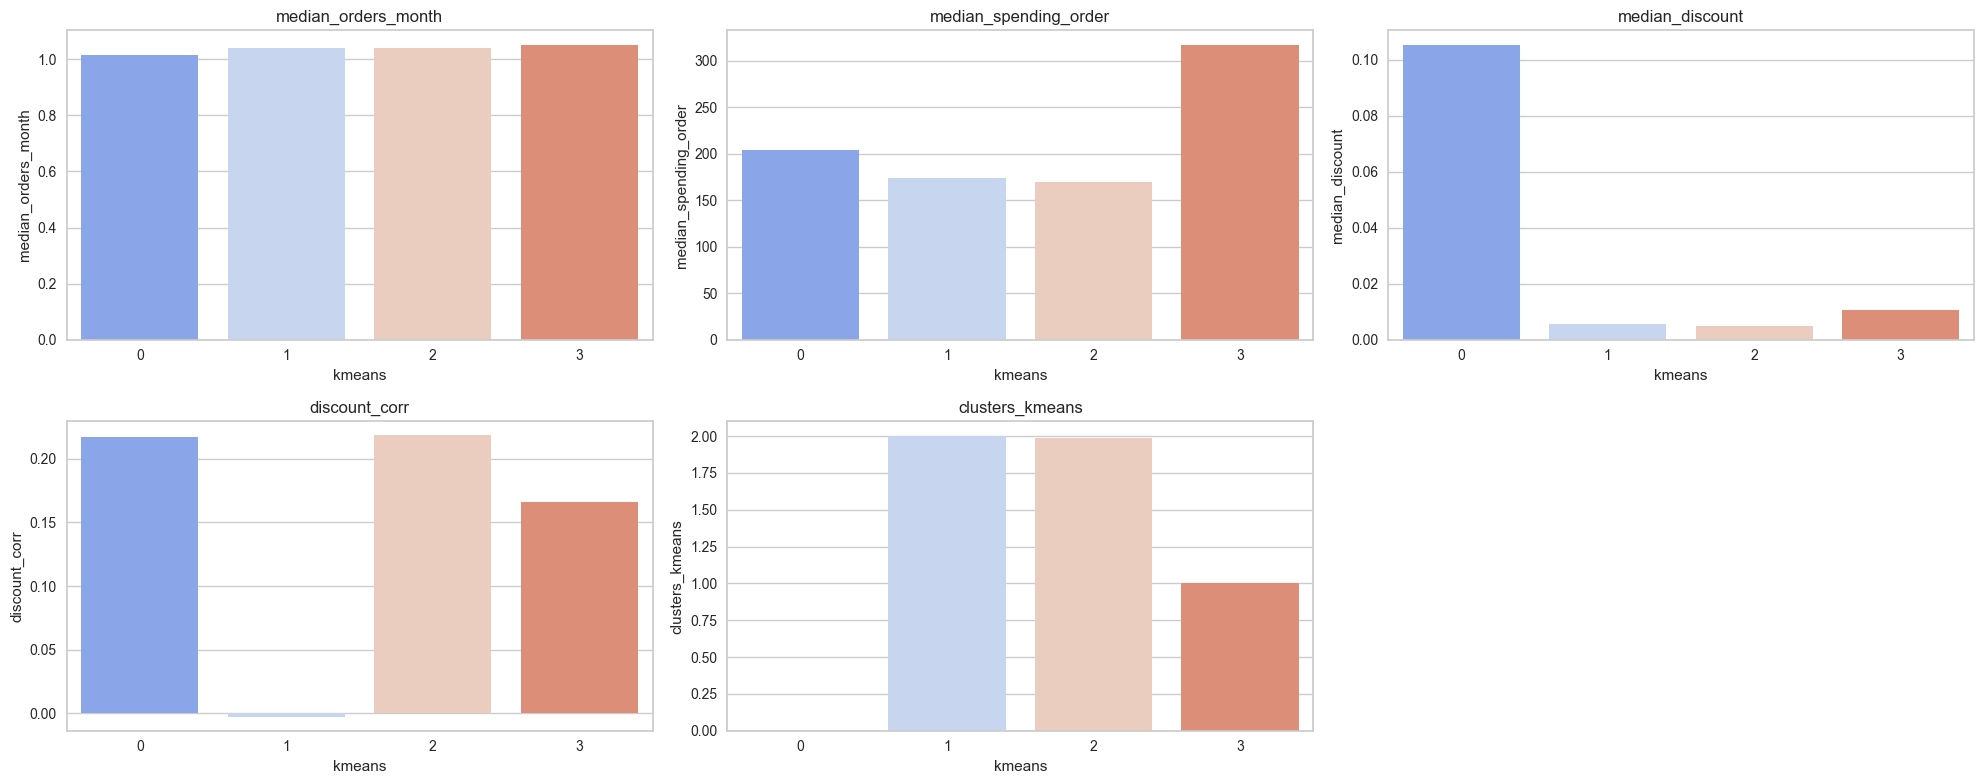

In [62]:
warnings.filterwarnings("ignore")
customer_aggregated_v1_outliers = customer_aggregated_v1_outliers.astype("float")
clusterizador_v1 = sc.Clustering(customer_aggregated_v1_outliers)

# 
clusterizador_v1.preparar_dataframe(scaler="robust")

customer_aggregated_v1_clustered = clusterizador_v1.modelo_kmeans(customer_aggregated_v1_outliers,4,random_state=seed)

sns.pairplot(customer_aggregated_v1_clustered, hue="clusters_kmeans")

clusterizador_v1.plot_clusters("kmeans")

warnings.filterwarnings("default")

In [63]:
clusterizador_v1.calcular_metricas("kmeans")

silhouette_score  davies_bouldin_index  cardinalidad
0          0.379152              0.931779           179

Again, all clusters roughly share the same monthly order frequency.

This set of 4 clusters divides very basically in:
- Cluster 0. Customers that do not tend to spend much (median_spending_order), react to discounts (spend more when there are, discount_corr) and have saved more on average (median_discount).
- Cluster 1. Customers that do not spend that much, but do not need discounts to spend and react the least to them.
- Cluster 2. Customers that do not spend much, can spend more if discounts are high, but do not necessarily wait for them to buy.
- Cluster 3. Customers that react to discounts, but also tend to spend a lot per order.

Below their cluster cardinality.

In [64]:
print("Clustering cardinality:")
customer_aggregated_v1_clustered.groupby("clusters_kmeans").size()

Clustering cardinality:


clusters_kmeans
0    179
1    210
2    194
3    188
dtype: int64

Now let's optimise k for the second combination of clusters:

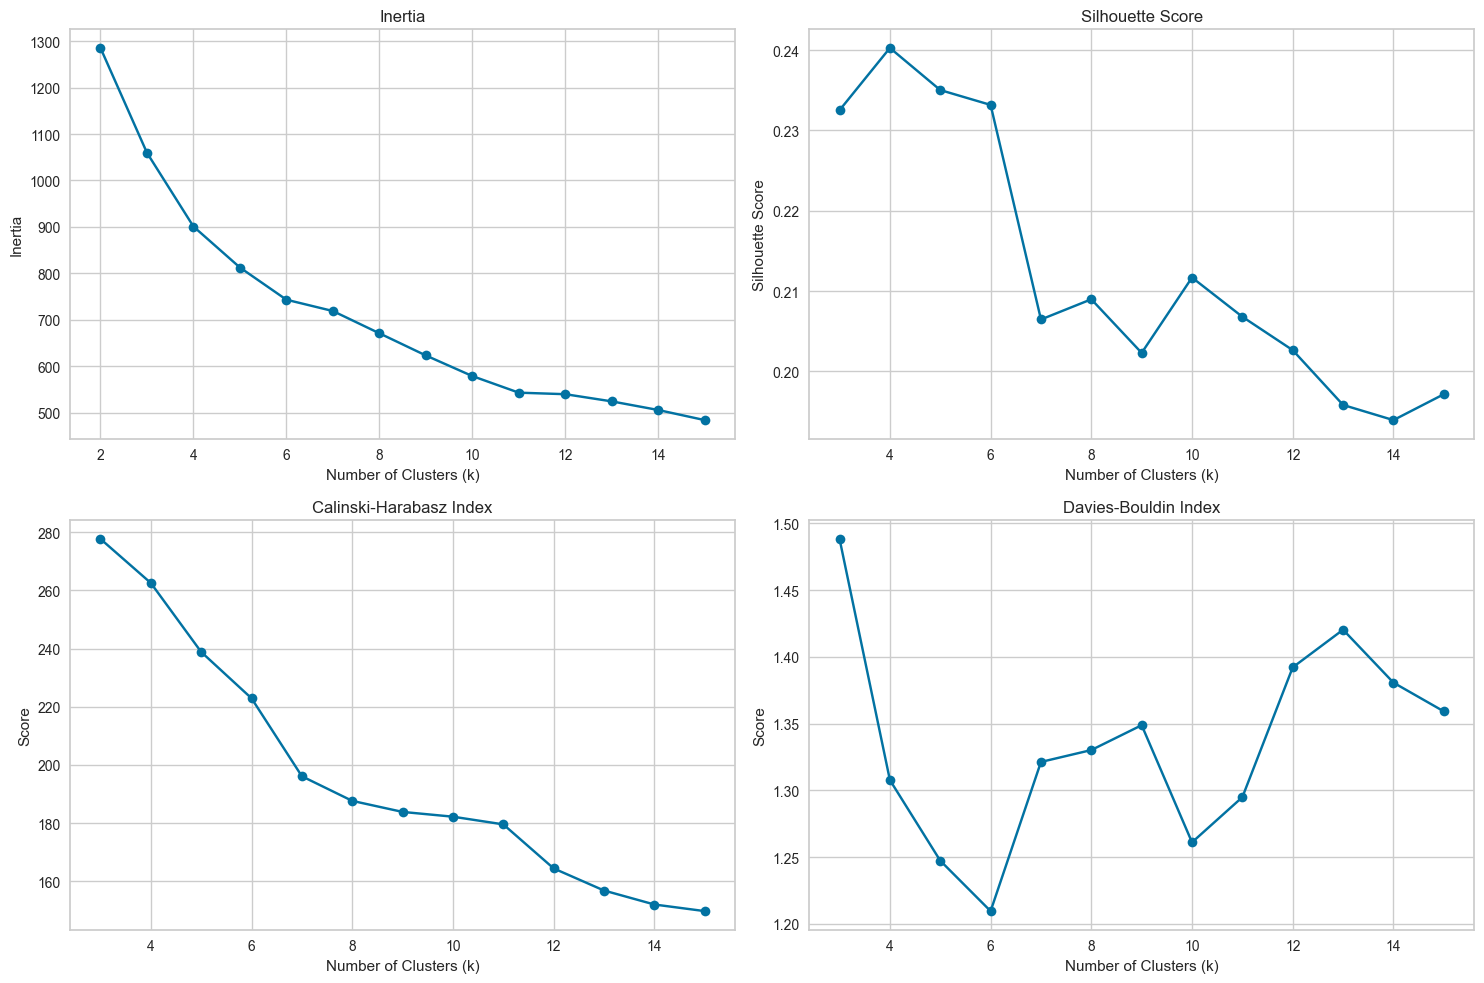

In [65]:
sc.choose_kmeans_k(customer_aggregated_v2_scaled)

Here metrics do not look that good. However 4 seems like the best compromise between metrics.

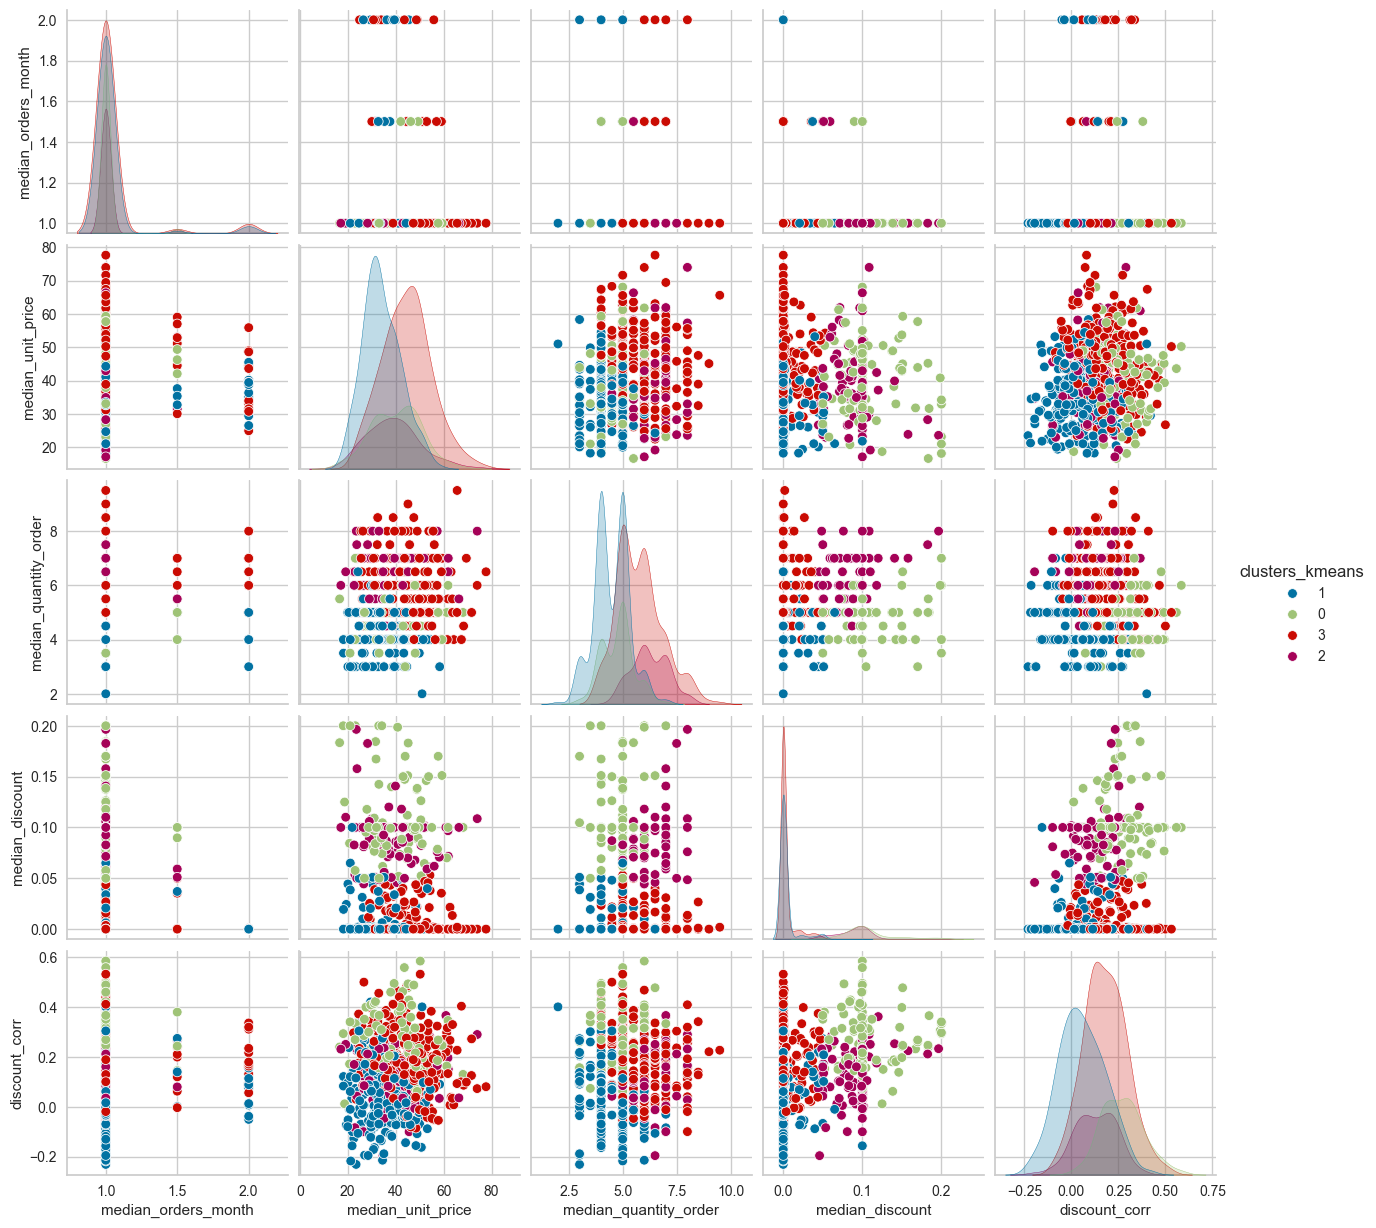

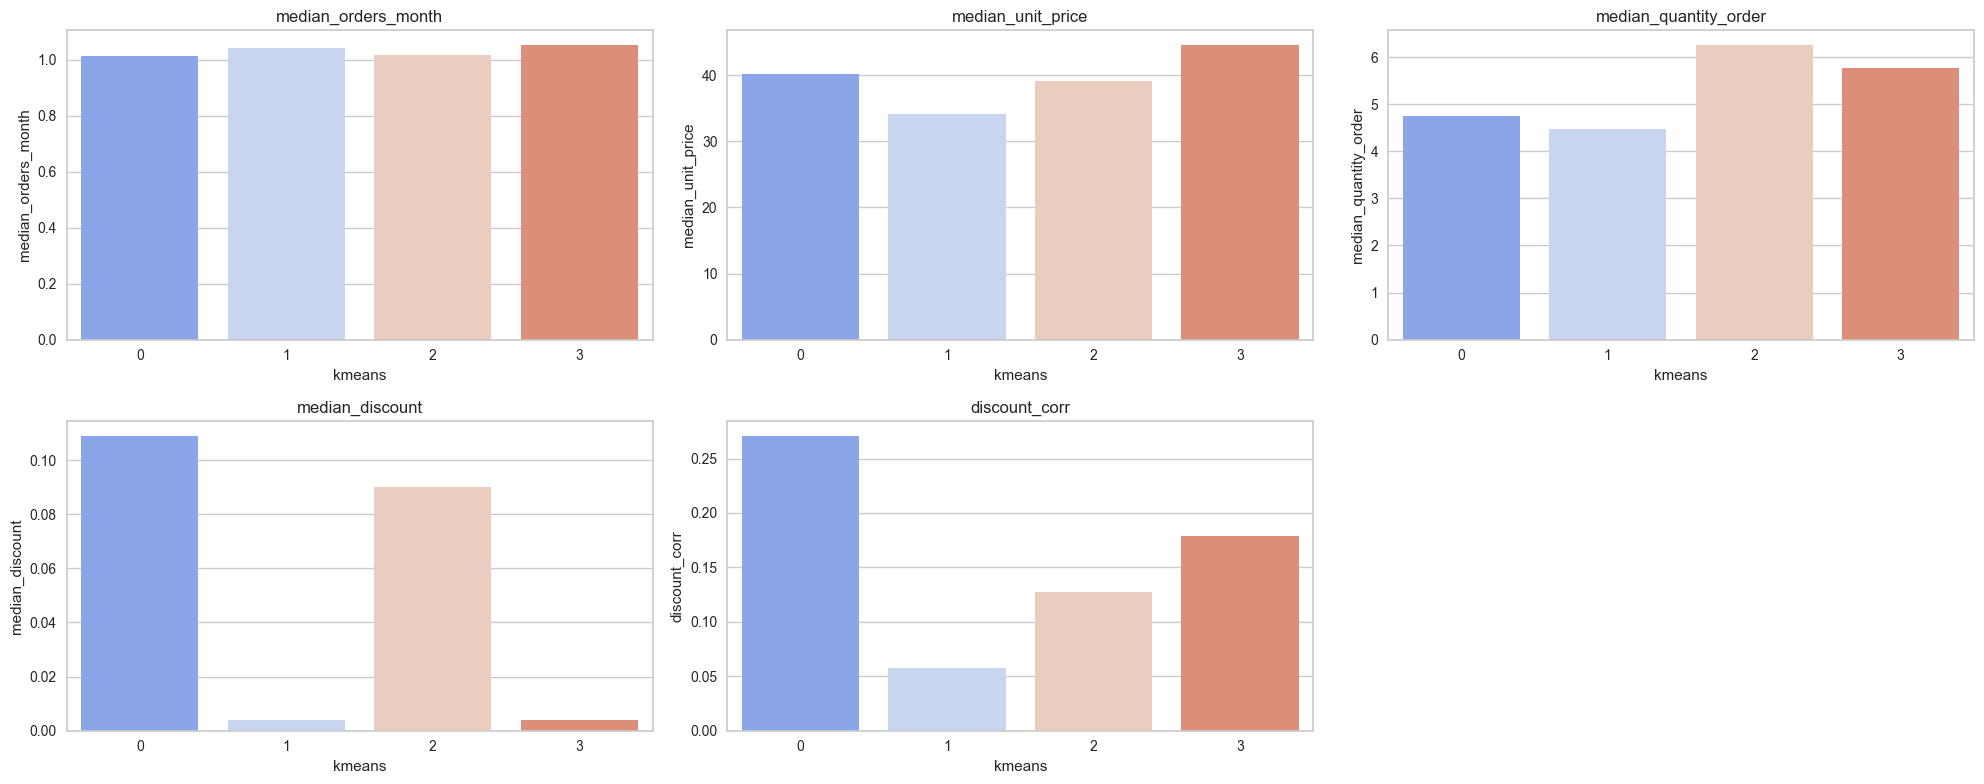

In [66]:
warnings.filterwarnings("ignore")
customer_aggregated_v2_outliers = customer_aggregated_v2_outliers.astype("float")
clusterizador_v2 = sc.Clustering(customer_aggregated_v2_outliers)

# 
clusterizador_v2.preparar_dataframe(scaler="robust")

customer_aggregated_v2_clustered = clusterizador_v2.modelo_kmeans(customer_aggregated_v2_outliers,4)

sns.pairplot(customer_aggregated_v2_clustered, hue="clusters_kmeans")

clusterizador_v2.plot_clusters("kmeans")
warnings.filterwarnings("default")

In [67]:
clusterizador_v2.calcular_metricas("kmeans")

silhouette_score  davies_bouldin_index  cardinalidad
0          0.207517              1.640194           111

Clusters do not seem as well separated here, and besides, the scores are worse, therefore this combination of features will not be chosen.

### 2.4.2 Kmeans with PCA

Optimising for k number of clusters for the first combination of features, reduced with PCA:

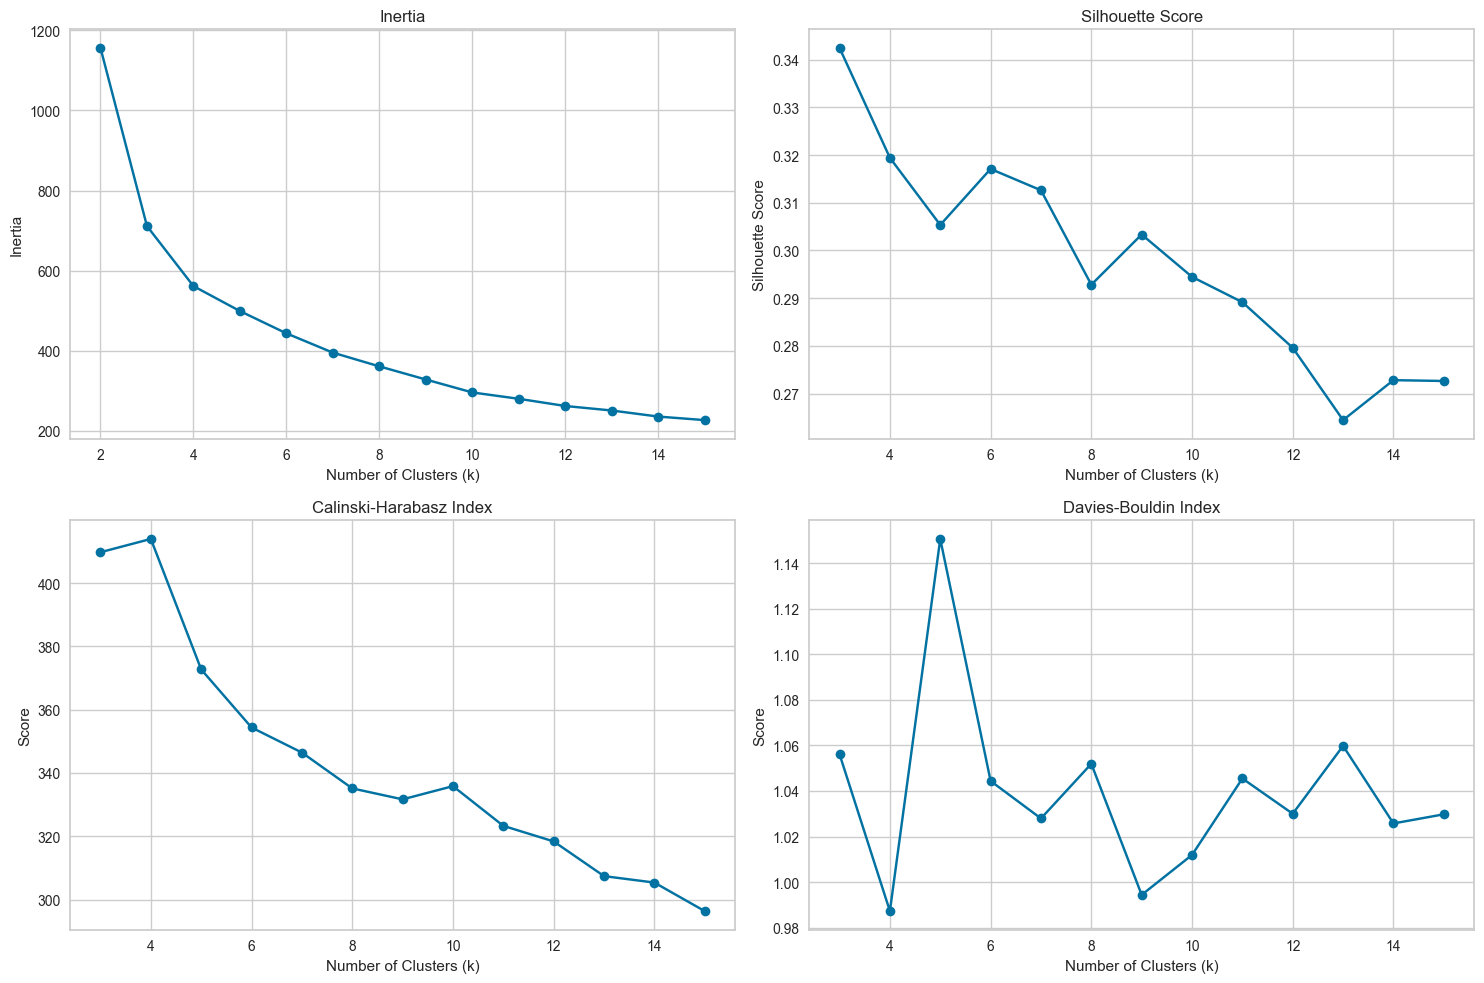

In [68]:
sc.choose_kmeans_k(X_pca_v1)

Here, 4 clusters display the best compromise in scores.

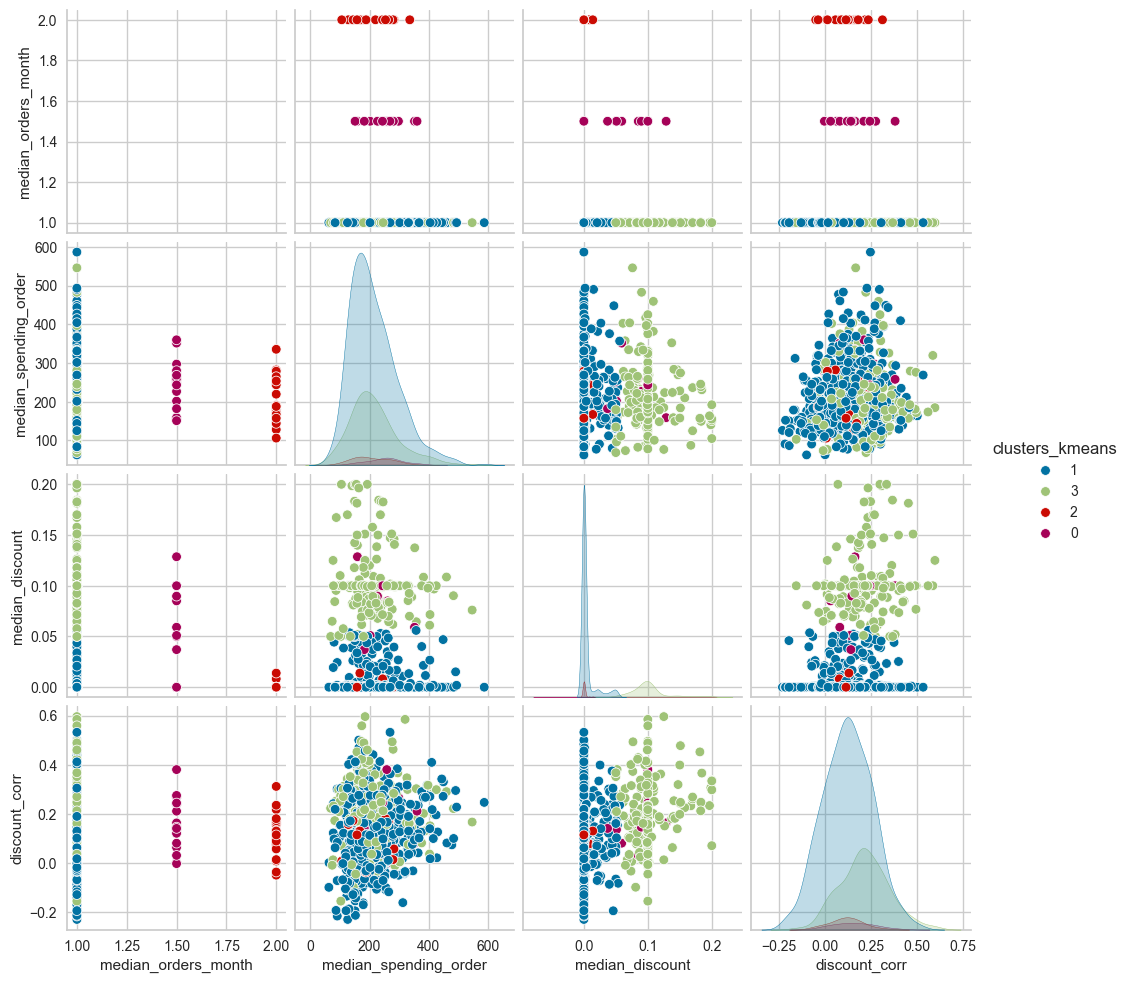

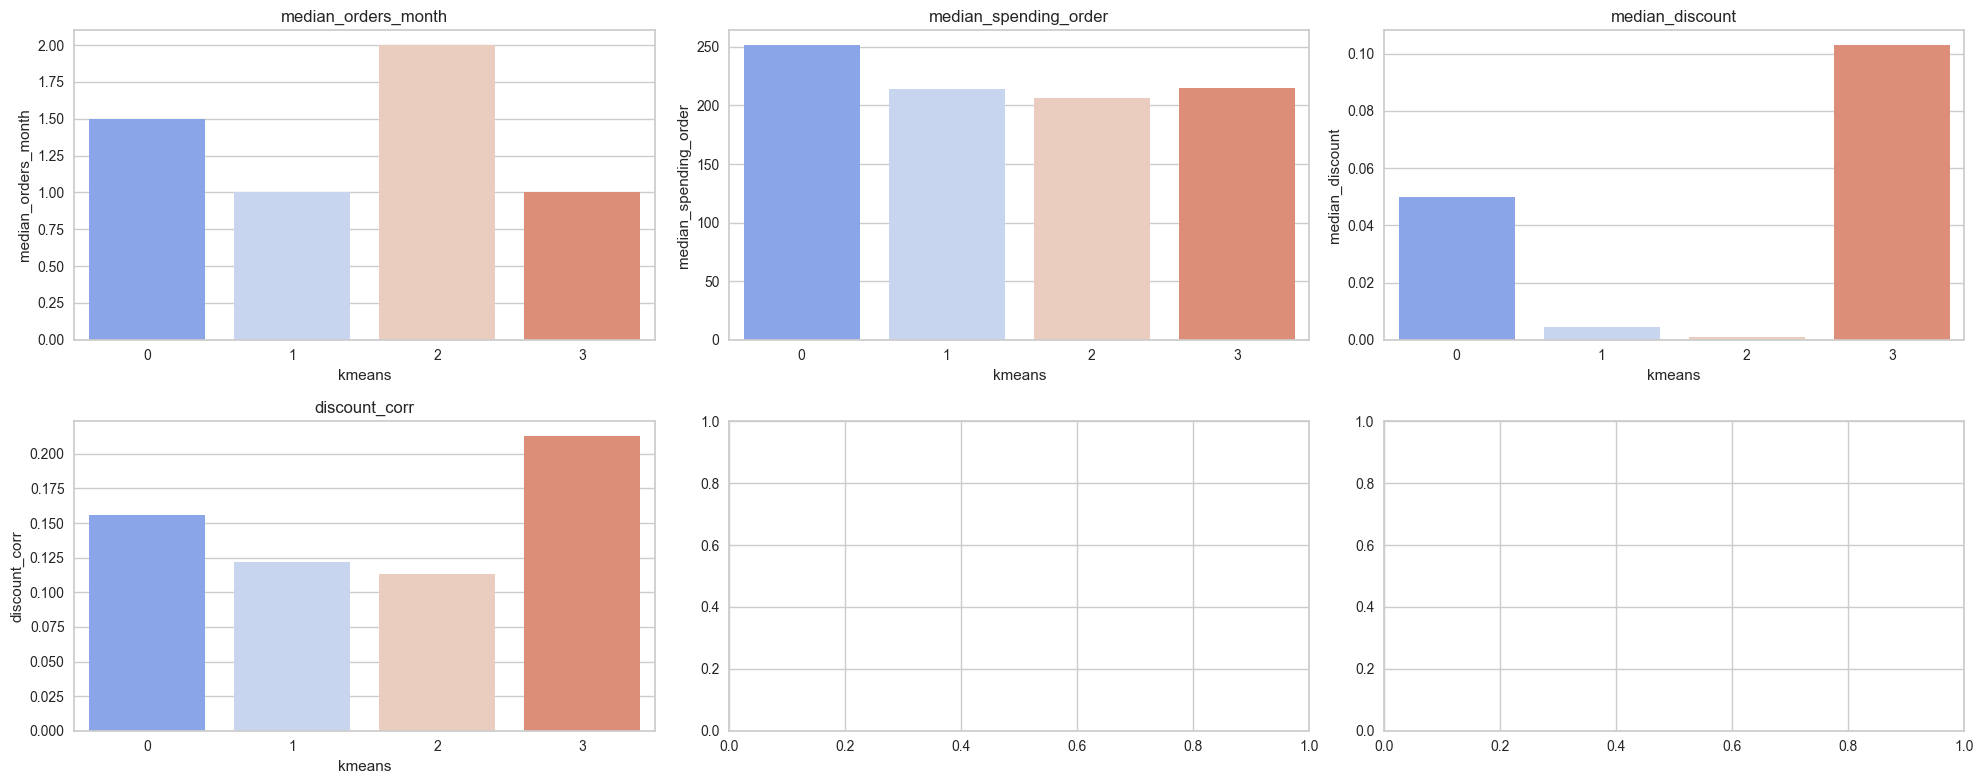

In [69]:
warnings.filterwarnings("ignore")
X_pca_v1 = X_pca_v1.astype("float")
clusterizador_v1_pca = sc.Clustering(X_pca_v1)

# 
clusterizador_v1_pca.preparar_dataframe(scaler="robust")

customer_aggregated_v1_pca_clustered = clusterizador_v1_pca.modelo_kmeans(customer_aggregated_v1_outliers.copy(),4)

sns.pairplot(customer_aggregated_v1_pca_clustered, hue="clusters_kmeans")

clusterizador_v1_pca.plot_clusters("kmeans",customer_aggregated_v1_outliers)
warnings.filterwarnings("default")

In [70]:
clusterizador_v1_pca.calcular_metricas("kmeans")

silhouette_score  davies_bouldin_index  cardinalidad
0          0.453333              0.559733            16

This time, PCA has completely focused on the frequency of orders per month.

- Cluster 0. Customers that buy frequently and tend to spend the most. They can react to discounts by spending more when they are offered.
- Cluster 1. Customers that buy the least frequently, and spend like most others. However, they do not need discounts to spend more and mostly do not enjoy them.
- Cluster 2. The most frequent buyers. They spend like most others per order, but are the least sensitive to discounts, meaning that they are high profitability customers, discount-wise.
- Cluster 3. The least desirable. These are customers that buy the least frequently, but only spend more when discounts are higher.

Finally, clustering metrics for this set of data displays the best metrics of all.

This clustering makes sense, however, cardinalities are not desirable.

In [71]:
print("Clustering cardinality:")
customer_aggregated_v1_pca_clustered.groupby("clusters_kmeans").size()

Clustering cardinality:


clusters_kmeans
0     16
1    543
2     21
3    191
dtype: int64

The second combination of features worked worse than the first combination, thus it will not be evaluated on its PCA variation.

# 3. Comments and selection

This evaluation builds on the previous notebook `notebooks/3_clustering_customers.ipynb`. 

The first thing to comment is that clusters from that notebook and this one, although very similar in "qualitaty", differ a lot in metrics from the evaluation. The difference between the 2 versions is that the former works with 'mean' metrics and this one with 'median' metrics, although the underlying data is the same. 

Hence, this raises the question of whether clusters from this notebook are really better than those of `notebooks/3_clustering_customers.ipynb`. The interpretation made is that clusters should only be compared with metrics in case they have undergone the same data transformations, and even then, cluster interpretability should be prioritised.

The chosen set of clusters is the 4 kmeans clusters for the first combination of features with median_orders_month, median_spending_order, median_discount and discount_corr, as it is the most simple set of features, shows good metrics, is explainable and its cardinality is correct.

In [73]:
# recreate chosen clusters
customer_aggregated_v1_clustered = clusterizador_v1.modelo_kmeans(customer_aggregated_v1_outliers,4,random_state=seed)

# save clusters data
path_dir = "../data/clusters"
os.makedirs(path_dir,exist_ok=True)
customer_aggregated_v1_clustered.to_pickle(f"{path_dir}/customer_aggregated_v1_median_k4.pkl")